In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')

In [3]:
hgg = ak.firsts(ak.from_parquet('/scratch365/cmoore24/training/hgg/batch/inputs/grm_ungrm/hgg.parquet'))
#qcd = ak.firsts(ak.from_parquet('/scratch365/cmoore24/training/hgg/batch/inputs/grm_ungrm/470to600.parquet'))
qcd = ak.from_parquet('/scratch365/cmoore24/training/hgg/batch/inputs/grm_ungrm/stitched.parquet')

In [4]:
hgg = hgg[(hgg.goodjets.btag_count==0)]

In [5]:
#qcd = qcd[(qcd.goodjets.btag_count==0)]
qcd = qcd[(qcd.btag_count==0)]

In [6]:
hgg = hgg[hgg.goodjets.msoftdrop <= 170]
hgg = hgg[hgg.goodjets.msoftdrop >= 80]
hgg = hgg[hgg.goodjets.pt <= 600]
hgg = hgg[hgg.goodjets.pt >= 450]

In [7]:
# qcd = qcd[qcd.goodjets.msoftdrop <= 170]
# qcd = qcd[qcd.goodjets.msoftdrop >= 80]
# qcd = qcd[qcd.goodjets.pt <= 600]
# qcd = qcd[qcd.goodjets.pt >= 450]
qcd = qcd[qcd.msoftdrop <= 170]
qcd = qcd[qcd.msoftdrop >= 80]
qcd = qcd[qcd.pt <= 600]
qcd = qcd[qcd.pt >= 450]

In [8]:
temp = {}
for i in hgg.groomed_ecf_ratios.fields:
    temp[f'{i}_Grm'] = hgg.groomed_ecf_ratios[i]
for i in  hgg.ungroomed_ecf_ratios.fields:
    temp[f'{i}_Ungrm'] = hgg.ungroomed_ecf_ratios[i]

hgg['goodjets', 'renamed_ecfs'] = ak.zip(temp)
hgg = hgg.goodjets

In [9]:
temp = {}
for i in qcd.groomed_ecf_ratios.fields:
    temp[f'{i}_Grm'] = qcd.groomed_ecf_ratios[i]
for i in  qcd.ungroomed_ecf_ratios.fields:
    temp[f'{i}_Ungrm'] = qcd.ungroomed_ecf_ratios[i]

qcd['goodjets', 'renamed_ecfs'] = ak.zip(temp)
qcd = qcd.goodjets

AttributeError: no field named 'groomed_ecf_ratios'

In [10]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            if sample[j].fields == []:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
            else:
                for k in sample[j].fields:
                    mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
        sample = sample[mask]
    return sample

In [11]:
hgg = nan_remover(hgg)
qcd = nan_remover(qcd)

In [12]:
path = '/scratch365/cmoore24/training/hgg/batch/outputs_grm/stitched_qcd/sculpted_qcd/both_1024nodes_3layers_256batch'

In [13]:
with open(f'{path}/selected_vars.txt', 'r') as f:
    ecf_list = f.readlines()
ecf_list = [item.strip() for item in ecf_list]

# with open(f'{path}/all_features.pkl', 'rb') as f:
#     ecf_list = pickle.load(f)

In [14]:
len(ecf_list)

240

In [15]:
model = f'{path}/traced_model.pt'

In [16]:
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [17]:
# class EnergyCorrelatorFunctionTagger(torch_wrapper):
#     def prepare_awkward(self, events, scaler, imap):
#         #fatjets = events

#         retmap = {
#             k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
#             for k in imap.keys()
#         }
#         x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
#         return (x,), {}

In [18]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler, imap):
        #fatjets = events

        arr_list = [x[:, np.newaxis] for x in imap['vars'].values()]
        new_list = []
        for i in arr_list:
            new_list.append(i.to_numpy())
        retmap = {'vars': ak.from_numpy(np.concatenate(new_list, axis=1))}

        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [19]:
tagger = EnergyCorrelatorFunctionTagger(model)

In [20]:
def imapper(array, ratio_list):
    imap = {}
    imap['vars'] = {}
    for i in ratio_list:
        try:
            imap['vars'][i] = array.renamed_ecfs[i]
        except:
            imap['vars'][i] = array[i]
    return imap

In [21]:
hgg_imap = imapper(hgg, ecf_list)
hgg_scores = tagger(hgg, scaler, hgg_imap)[:,0]

In [24]:
hgg['ecf_scores'] = hgg_scores

In [27]:
#ak.to_parquet(hgg, '/scratch365/cmoore24/weaver-core/my_attempt/ecf_comp/ecfs_sig.parquet')

  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 340
  num_rows: 43010
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [23]:
qcd_imap = imapper(qcd, ecf_list)
qcd_scores = tagger(qcd, scaler, qcd_imap)[:,0]

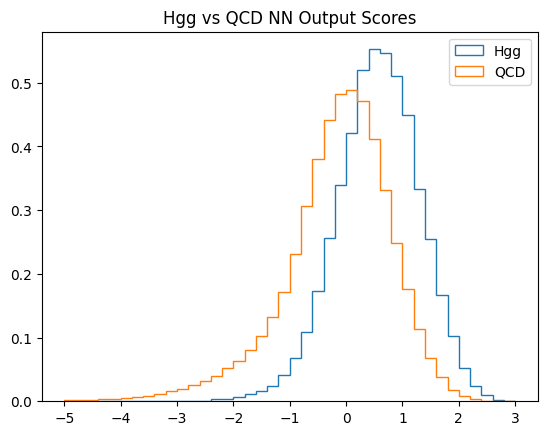

In [25]:
pltrange = (-5, 3)
plt.hist(hgg_scores, bins=40, histtype='step', label='Hgg', density=True, range=pltrange)
plt.hist(qcd_scores, bins=40, histtype='step', label='QCD', density=True, range=pltrange)
plt.title(f'Hgg vs QCD NN Output Scores')
plt.legend()
plt.show()

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: overflow encountered in exp
  return impl(*broadcasted_args, **(kwargs or {}))


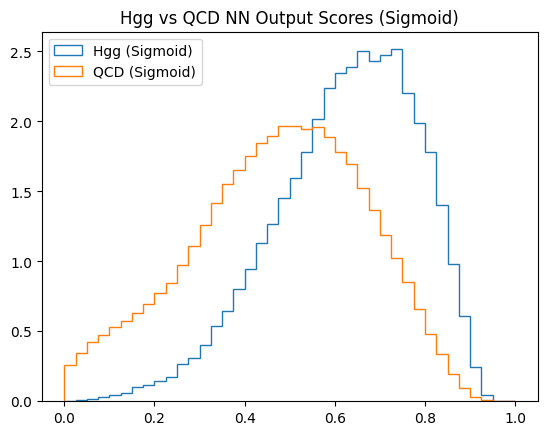

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid to the scores
hgg_scores_sigmoid = sigmoid(hgg_scores)
qcd_scores_sigmoid = sigmoid(qcd_scores)

# Plot the histograms for scores after applying sigmoid
pltrange = (0, 1)  # Adjust the range to match the sigmoid output
plt.hist(hgg_scores_sigmoid, bins=40, histtype='step', label='Hgg (Sigmoid)', density=True, range=pltrange)
plt.hist(qcd_scores_sigmoid, bins=40, histtype='step', label='QCD (Sigmoid)', density=True, range=pltrange)
plt.title(f'Hgg vs QCD NN Output Scores (Sigmoid)')
plt.legend()
plt.show()

In [25]:
mask = ~np.isnan(qcd_scores)
qcd_scores = qcd_scores[mask]# & (qcd_scores > -6) & (qcd_scores < 6)]
qcd_train = qcd[mask]

In [26]:
mask = ~np.isnan(hgg_scores)
hgg_scores = hgg_scores[mask]# & (hgg_scores > -6) & (hgg_scores < 6)]
hgg_train = hgg[mask]

In [27]:
bkg_zeros = ak.zeros_like(qcd_scores_sigmoid)
sig_ones = ak.ones_like(hgg_scores_sigmoid)
combined = ak.concatenate([qcd_scores_sigmoid,hgg_scores_sigmoid])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [28]:
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)

In [29]:
hrange=(np.floor(ak.min(hgg_scores_sigmoid)), np.ceil(ak.max(hgg_scores_sigmoid)))

In [30]:
hgg_hist = np.histogram(hgg_scores_sigmoid, bins=20,
                range=hrange
                )
qcd_hist = np.histogram(qcd_scores_sigmoid, bins=20, 
                 range=hrange
                )

In [31]:
sig_sums = []
for i in range(len(hgg_hist[0])+1):
    sig_sums.append(sum(hgg_hist[0][len(hgg_hist[0])-i:]))

bkg_sums = []
for i in range(len(qcd_hist[0])+1):
    bkg_sums.append(sum(qcd_hist[0][len(qcd_hist[0])-i:]))

In [32]:
sig_ratios = []
for i in sig_sums:
    sig_ratios.append(i/sig_sums[-1])
bkg_ratios = []
for i in bkg_sums:
    bkg_ratios.append(i/bkg_sums[-1])

In [33]:
wp_ratios = {}
for i in range(len(hgg_hist[1])):
    wp_ratios[str(hgg_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

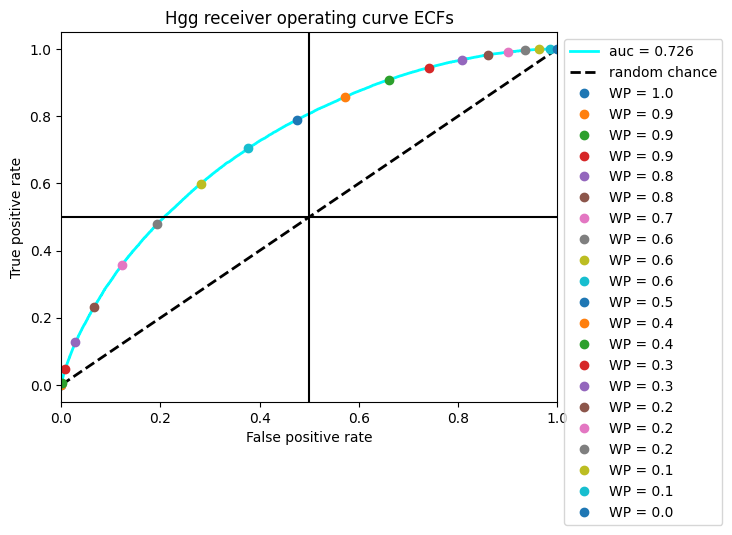

In [34]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg receiver operating curve ECFs")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
for i in wp_ratios:
    plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {float(i):.1f}')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [35]:
def get_percentile_cut(data, target_percentile=0.25):
    data = np.array(data)
    cut_value = np.percentile(data, (1 - target_percentile) * 100)
    return cut_value

In [36]:
cut = get_percentile_cut(hgg_scores_sigmoid)
cut
#cut = 0.899

0.7424593418836594

In [80]:
mask = ~((qcd_scores_sigmoid >= cut))
qcd_cut_msd = qcd_train.msoftdrop[mask]
qcd_fail_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
qcd_fail_hist.fill(msd=qcd_cut_msd);

In [81]:
mask = ((qcd_scores_sigmoid >= cut))
qcd_cut_msd = qcd_train.msoftdrop[mask]
qcd_pass_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
qcd_pass_hist.fill(msd=qcd_cut_msd);

In [82]:
with open('/afs/crc.nd.edu/user/c/cmoore24/Public/hgg/ml/ml_processor_work/jsons/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
with open('/afs/crc.nd.edu/user/c/cmoore24/Public/hgg/ml/ml_processor_work/jsons/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [83]:
# scale = ((44.99*(xsecs['qcd']['qcd_470to600']*1000))/totals['qcd']['470to600'])
# qcd_pass_hist.view(flow=True)[:] *= scale
# qcd_fail_hist.view(flow=True)[:] *= scale

In [84]:
total_qcd_hist = qcd_pass_hist + qcd_fail_hist

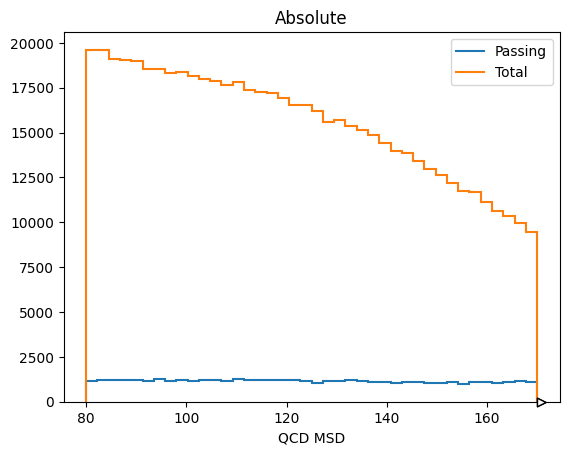

In [91]:
qcd_pass_hist.plot1d(density=False, label='Passing', yerr=False)
total_qcd_hist.plot1d(density=False, label='Total', yerr=False)
plt.title('Absolute')
plt.legend()
plt.show()

In [92]:
sum(qcd_pass_hist.values()), sum(total_qcd_hist.values())

(45787.0, 622578.0)

In [93]:
sum(qcd_pass_hist.values())/sum(total_qcd_hist.values()) * 100

7.354419847794172

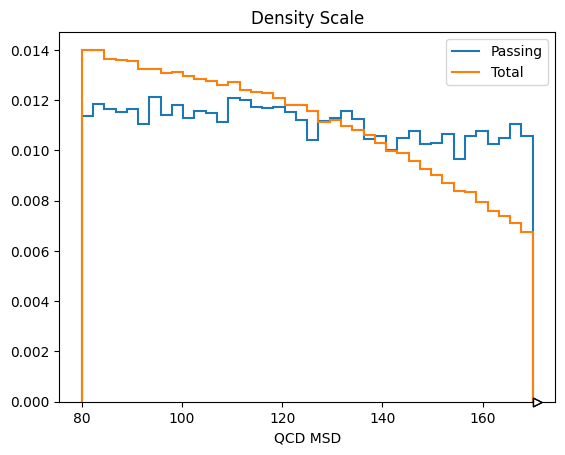

In [94]:
qcd_pass_hist.plot1d(density=True, label='Passing', yerr=False)
total_qcd_hist.plot1d(density=True, label='Total', yerr=False)
plt.title('Density Scale')
plt.legend()
plt.show()

In [72]:
mask = ~((hgg_scores_sigmoid >= cut))
hgg_cut_msd = hgg_train.msoftdrop[mask]
hgg_fail_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Hgg MSD').Weight()
hgg_fail_hist.fill(msd=hgg_cut_msd);

In [73]:
mask = ((hgg_scores_sigmoid >= cut))
hgg_cut_msd = hgg_train.msoftdrop[mask]
hgg_pass_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Hgg MSD').Weight()
hgg_pass_hist.fill(msd=hgg_cut_msd);

In [74]:
scaleHgg = ((44.99*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
hgg_fail_hist.view(flow=True)[:] *= scaleHgg
hgg_pass_hist.view(flow=True)[:] *= scaleHgg

In [75]:
total_hgg_hist = hgg_pass_hist + hgg_fail_hist

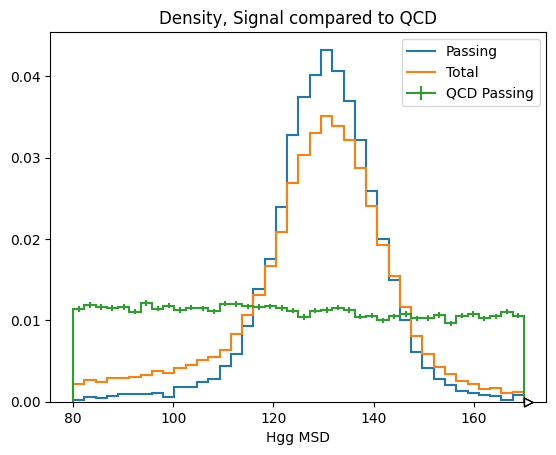

In [79]:
hgg_pass_hist.plot1d(density=True, label='Passing', yerr=False)
total_hgg_hist.plot1d(density=True, label='Total', yerr=False)
qcd_pass_hist.plot1d(density=True, label='QCD Passing')
plt.title('Density, Signal compared to QCD')
plt.legend()
plt.show()

In [51]:
sum(hgg_pass_hist.values()), sum(total_hgg_hist.values())

(7.781435290328474, 31.119951941345263)